Using device: cpu
Generating sample images...


<ipython-input-12-cd72805656ea>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(weights_path, map_location=DEVICE))


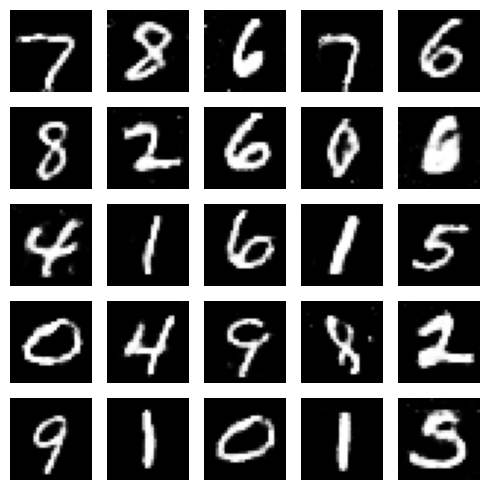

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import json
import os

# Set device configuration
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load generator model from JSON
def load_generator_model(json_path, weights_path):
    with open(json_path, 'r') as file:
        model_info = json.load(file)

    # Define the Generator model based on loaded architecture
    class Gen(nn.Module):
        def __init__(self, z_dim, hidden_layers):
            super(Gen, self).__init__()
            layers = []
            input_size = z_dim
            for hidden in hidden_layers:
                layers.append(nn.Linear(input_size, hidden))
                layers.append(nn.LeakyReLU(0.2))
                layers.append(nn.BatchNorm1d(hidden))
                input_size = hidden
            layers.append(nn.Linear(input_size, 28 * 28))
            layers.append(nn.Tanh())
            self.net = nn.Sequential(*layers)

        def forward(self, z_input):
            img_out = self.net(z_input)
            return img_out.view(img_out.size(0), 1, 28, 28)

    # Initialize the generator with the parameters from the JSON file
    generator = Gen(z_dim=model_info['latent_size'], hidden_layers=model_info['hidden_layers']).to(DEVICE)

    # Load weights with map_location set to the current device
    generator.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    generator.eval()

    return generator

# Generate images using the generator
def generate_images(generator, sample_count=25):
    with torch.no_grad():
        noise_input = torch.randn(sample_count, 100).to(DEVICE)  # Assuming Z_DIM is 100
        generated_imgs = generator(noise_input).cpu()

    fig, axes = plt.subplots(5, 5, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_imgs[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Main evaluation function
def run_evaluation():
    print(f"Using device: {DEVICE}")

    # Load the generator model and weights
    generator = load_generator_model('/content/generator.json', '/content/generator.h5')

    # Generate and display sample images
    print("Generating sample images...")
    generate_images(generator)

if __name__ == "__main__":
    run_evaluation()